In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm, trange

TRAIN_PATH = "absc_data/train.csv"
TEST_PATH = "absc_data/test.csv"

In [ ]:
train = pd.read_csv(TRAIN_PATH)
train, val = train_test_split(train, test_size=0.25, random_state=42)
test = pd.read_csv(TEST_PATH)

print(len(train), len(val), len(test))

In [ ]:
# Constants
CLASSES = train['Polarity'].unique()
NUM_CLASSES = len(CLASSES)
CLASS2INDEX = {c: i for i, c in enumerate(CLASSES)}
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class BertDataset(Dataset):
    def __init__(self, data, tokenizer, *, max_len=128):
        super(BertDataset, self).__init__()
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
    # END __init__

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = f"{row['Aspect Term']} [SEP] {row['Sentence']}"
        label = NUM_CLASSES * [0]
        label[CLASS2INDEX[row['Polarity']]] = 1

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'label': torch.tensor(label)
        }
    # END __getitem__
# END BertDataset

In [ ]:
class BertModel(nn.Module):
    def __init__(self, model_name, num_classes):
        super(BertModel, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(model_name)
        # self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, num_classes)
    # END __init__

    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=False
        )
        # output = self.drop(output)
        return self.out(output)
    # END forward
# END BertModel

In [ ]:
BATCH_SIZE = 128
MAX_LEN = 100

tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = BertDataset(train, tokenizer, max_len=MAX_LEN)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_dataset = BertDataset(val, tokenizer, max_len=MAX_LEN)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
)

In [ ]:
EPOCHS = 50
LEARNING_RATE = 1e-3

model = BertModel("bert-base-uncased", NUM_CLASSES)
model.load_state_dict(torch.load("model.pth", weights_only=True))

model = model.to(DEVICE, non_blocking=True)
for bert_param in model.bert.parameters():
    bert_param.requires_grad = False

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [ ]:
best_acc = 0
for epoch in trange(EPOCHS):
    tqdm.write(f"\nEpoch {epoch + 1}/{EPOCHS}")

    correct = 0
    train_loss = 0

    tqdm.write("Training...")
    model.train()
    for i, batch in tqdm(enumerate(train_loader),
                         leave=False,
                         total=len(train_loader),
                         colour='magenta'):
        input_ids = batch['input_ids'].to(DEVICE, non_blocking=True)
        attention_mask = batch['attention_mask'].to(DEVICE, non_blocking=True)
        token_type_ids = batch['token_type_ids'].to(DEVICE, non_blocking=True)
        label = batch['label'].to(DEVICE, non_blocking=True)

        optimizer.zero_grad()
        output = model(input_ids, attention_mask, token_type_ids)
        label = label.type_as(output)
        loss = loss_fn(output, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(output, dim=1)
        correct += torch.sum(pred == torch.argmax(label, dim=1)).item()
    # END for i, batch in enumerate(train_loader)

    tqdm.write(f"Training Loss:            {train_loss}")
    tqdm.write(f"Training Accuracy:        {correct / len(train)}")

    correct = 0
    val_loss = 0

    tqdm.write("\nValidating...")
    with torch.inference_mode():
        model.eval()
        for batch in tqdm(val_loader, leave=False, colour='green'):
            input_ids = batch['input_ids'].to(DEVICE, non_blocking=True)
            attention_mask = batch['attention_mask'].to(
                DEVICE, non_blocking=True)
            token_type_ids = batch['token_type_ids'].to(
                DEVICE, non_blocking=True)
            label = batch['label'].to(DEVICE, non_blocking=True)

            output = model(input_ids, attention_mask, token_type_ids)
            label = label.type_as(output)
            loss = loss_fn(output, label)
            val_loss += loss.item()

            _, pred = torch.max(output, dim=1)
            correct += torch.sum(pred == torch.argmax(label, dim=1)).item()
        # END for batch in val_loader
    # END with torch.inference_mode()

    val_acc = correct / len(val)

    tqdm.write(f"Validation Loss:          {val_loss}")
    tqdm.write(f"Validation Accuracy:      {val_acc}")
    tqdm.write(f"Best Validation Accuracy: {best_acc}")

    if val_acc > best_acc:
        tqdm.write("Saving model...\n")
        best_acc = val_acc
        torch.save(model.state_dict(), "model.pth")
    # END if val_loss < best_loss
# END for epoch in trange(EPOCHS)

In [18]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")
test_dataset = BertDataset(test, tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
)

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

model = BertModel("bert-base-uncased", NUM_CLASSES)
model.load_state_dict(torch.load("model.pth", weights_only=True))
model = model.to(DEVICE, non_blocking=True)
model.eval()

loss_fn = nn.CrossEntropyLoss()
correct = []
preds = []
test_loss = 0

with torch.inference_mode():
    for batch in tqdm(test_loader, colour='cyan'):
        input_ids = batch['input_ids'].to(DEVICE, non_blocking=True)
        attention_mask = batch['attention_mask'].to(DEVICE, non_blocking=True)
        token_type_ids = batch['token_type_ids'].to(DEVICE, non_blocking=True)
        label = batch['label'].to(DEVICE, non_blocking=True)

        output = model(input_ids, attention_mask, token_type_ids)
        label = label.type_as(output)
        loss = loss_fn(output, label)
        test_loss += loss.item()

        corr = torch.argmax(label, dim=1).numpy(force=True)
        pred = torch.argmax(output, dim=1).numpy(force=True)

        correct.extend(corr)
        preds.extend(pred)
        # correct += torch.sum(pred == torch.argmax(label, dim=1)).item()
    # END for batch in test_loader
# END with torch.inference_mode()

tqdm.write(f"Test Loss:     {test_loss}")
# tqdm.write(f"Test Accuracy: {correct / len(test)}")

  0%|          | 0/10 [00:00<?, ?it/s]

Test Loss:     7.662157654762268


              precision    recall  f1-score   support

    positive       0.76      0.88      0.81       628
     neutral       0.57      0.34      0.42       228
    negative       0.65      0.67      0.66       338
    conflict       0.00      0.00      0.00        17

    accuracy                           0.71      1211
   macro avg       0.50      0.47      0.47      1211
weighted avg       0.68      0.71      0.69      1211



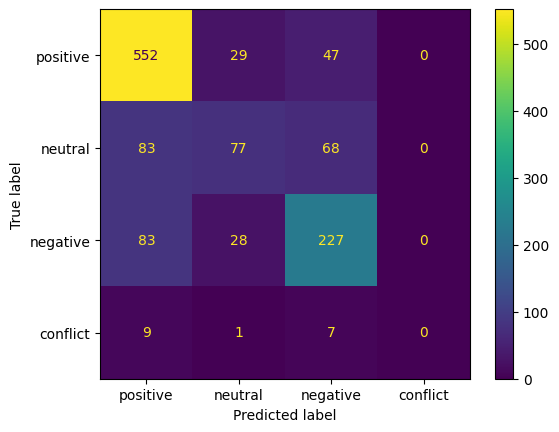

In [22]:
print(classification_report(correct, preds, target_names=CLASSES, zero_division=0))
cm_display = ConfusionMatrixDisplay.from_predictions(
    correct, preds, display_labels=CLASSES)